In [27]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

In [28]:
# get data and change the transaction_id and product_id type to number
df = pd.read_csv('edzd_trans_data.csv')

# print column types
for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)
    
# change the type of product_id to int and number them from 1 to number of different product_ids
df['product_id'] = df['product_id'].astype('category')
df['product_id'] = df['product_id'].cat.codes

# change the type of transaction_id to int and number them from 1 to number of different transaction_ids
df['transaction_id'] = df['transaction_id'].astype('category')
df['transaction_id'] = df['transaction_id'].cat.codes


Type of column transaction_id is object
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is object
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [29]:
# filter out customer_id = -1
df_filtered = df[df['customer_id'] != '-1']

# change customed_id to numeric
le = LabelEncoder()
df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])

# print the result
print(df_filtered)

         transaction_id       sales_datetime  customer_id  product_id  \
6789             501717  2011-01-03 10:06:00        92354       26838   
7478            2418844  2011-01-03 12:01:00       113131       44520   
7479            2418844  2011-01-03 12:01:00       113131       57544   
8581            3704341  2011-01-03 13:49:00         2419       27992   
8582            3704341  2011-01-03 13:49:00         2419       27992   
...                 ...                  ...          ...         ...   
8159528         3026494  2014-10-01 20:51:00       119861       31054   
8159529          797946  2014-10-01 20:54:00         7589       51188   
8159530          797946  2014-10-01 20:54:00         7589       44626   
8159532          476485  2014-10-01 20:56:00        61463       39927   
8159533          476485  2014-10-01 20:56:00        61463       30249   

         quantity    price  category_id  parent_id  store_id  department_id  \
6789          1.0  35.0000          110     

/tmp/ipykernel_25205/2748515793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])


In [32]:
# use the the data to cluster customers into
# groups of those who have similar purchasing habits
# when it comes to the size of their transactions and amount of money spent

# we will need customer_id, transaction_id and price
df_shortened_transactions = df_filtered[['transaction_id', 'customer_id']]
df_shortened_prices = df_filtered[['price', 'customer_id']]

# for each customer calculate the number of transactions and the amount of money
# spent in general
df_grouped_transactions = df_shortened_transactions.groupby('customer_id').count()
df_grouped_prices = df_shortened_prices.groupby('customer_id').sum()

frames = [df_grouped_transactions, df_grouped_prices]
df_grouped = pd.concat(frames, axis=1)

# rename the columns
df_grouped.rename(columns = {"transaction_id":"transaction_count", "price":"total_money_spent"}, inplace=True)

# print the result
print(df_grouped[:10])

             transaction_count  total_money_spent
customer_id                                      
0                            9             252.99
1                            6              20.50
2                           40             410.80
3                            1              10.00
4                            6              60.87
5                            1              11.25
6                           26             141.40
7                            3              41.56
8                            4              15.60
9                            1               7.50


In [33]:
# we need to eliminate some customers, as the data is too large to analyse with
# the DB-scan algorithm

print(df_grouped.shape[0])
df_grouped = df_grouped[:35000]

204441


In [34]:
# cluster the data with DBSCAN
clustering = DBSCAN(eps=20.0, min_samples=5).fit(df_grouped)
df_grouped.loc[:,'Cluster'] = clustering.labels_

# visualize the distribution of clusters, we will use value_counts() and convert it into a dataframe. 
df_grouped.Cluster.value_counts().to_frame()

,Cluster
0,34446
-1,448
2,23
4,17
5,10
1,9
3,9
7,7
9,7
6,5


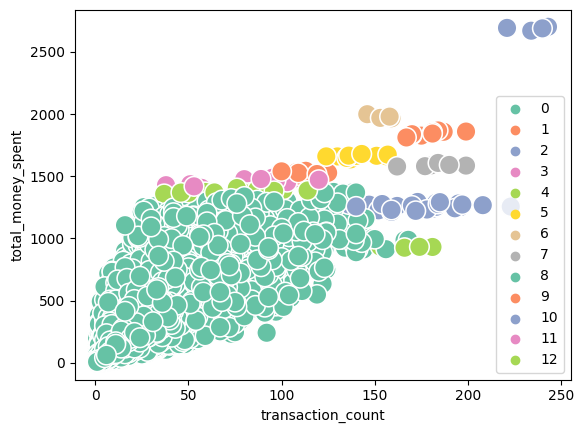

In [39]:
outliers = df_grouped[df_grouped['Cluster']==-1]

# generate plot
my_plot = sns.scatterplot(data=df_grouped[df_grouped['Cluster']!=-1], x='transaction_count', y='total_money_spent',
                hue='Cluster', palette='Set2', legend='full', s=200)

# show outliers on the plot - the plot becomes unclear, so the line below is commented
# my_plot.scatter(outliers['transaction_count'], outliers['total_money_spent'], s=10, label='outliers', c="k")
my_plot.legend()
plt.show()